In [1]:
# libraries 
import numpy as np
from numpy.random import normal
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
import os
from tqdm import tqdm
from pytz import timezone 
import scipy
from scipy.integrate import simps as simps
import pickle
from datetime import datetime, time, timedelta
import matplotlib.cm as cm
# import functions
from funs import *

---

In [7]:
bonds_names = ['US', 'FV', 'TY', 'TU']# import data
data = {}
for file in os.listdir('./TB_out_pickled_data'):
    try:
        with open('./TB_out_pickled_data/{}'.format(file), 'rb') as f:
            loaded_data = pickle.load(f)
        data.update({file[:-7] :loaded_data})
    except:
        None
data.keys()


dict_keys(['FV_2002', 'TY_2000', 'FV_2010', 'TY_2012', 'TU_2002', 'TU_2010', 'US_2014', 'US_2006', 'TU_2012', 'TU_2000', 'US_2004', 'US_2008', 'TY_2010', 'FV_2012', 'TY_2002', 'FV_2000', 'US_2012', 'US_2000', 'TU_2004', 'TU_2008', 'TY_2006', 'FV_2004', 'FV_2008', 'TY_2014', 'FV_2014', 'TY_2008', 'FV_2006', 'TY_2004', 'US_2002', 'US_2010', 'TU_2014', 'TU_2006', 'US_2007', 'TU_2003', 'TU_2011', 'FV_2003', 'TY_2001', 'FV_2011', 'TY_2013', 'TY_2011', 'FV_2013', 'TY_2003', 'FV_2001', 'US_2005', 'US_2009', 'TU_2013', 'TU_2001', 'TY_2007', 'FV_2005', 'FV_2009', 'TU_2005', 'TU_2009', 'US_2013', 'US_2001', 'TU_2007', 'US_2003', 'US_2011', 'TY_2009', 'FV_2007', 'TY_2005'])

----

In [4]:
# Define start and end times
start_time = datetime.strptime('00:00', '%H:%M')
end_time = datetime.strptime('23:55', '%H:%M')

# Generate list of time strings every 5 minutes
time_list = []
current_time = start_time

while current_time <= end_time:
    time_list.append(current_time.strftime('%H:%M'))
    current_time += timedelta(minutes=5)

# open_time_list = np.array(time_list[48:])
open_time_list = np.array(time_list[131:])

1it [00:02,  2.38s/it]/var/folders/kr/wkpxrqbj4g9frynmfl2x56_00000gp/T/ipykernel_78854/2741585444.py:37: RuntimeWarning: divide by zero encountered in divide
  allhatmu = ((results['LLS_Der_mean'] + hat_theta*results['LLS_mean'])/hat_theta)[hat_theta>0]
12it [00:31,  2.66s/it]


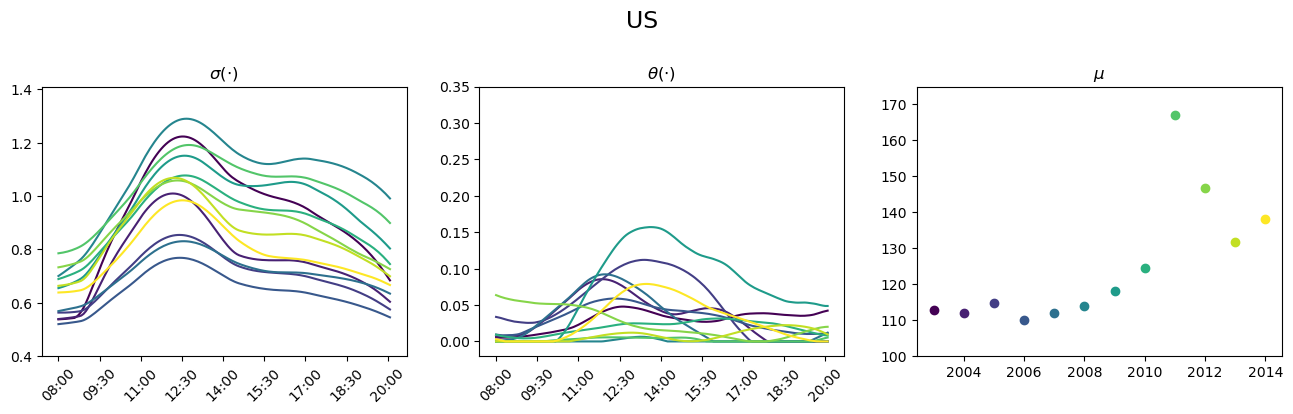

12it [00:32,  2.75s/it]


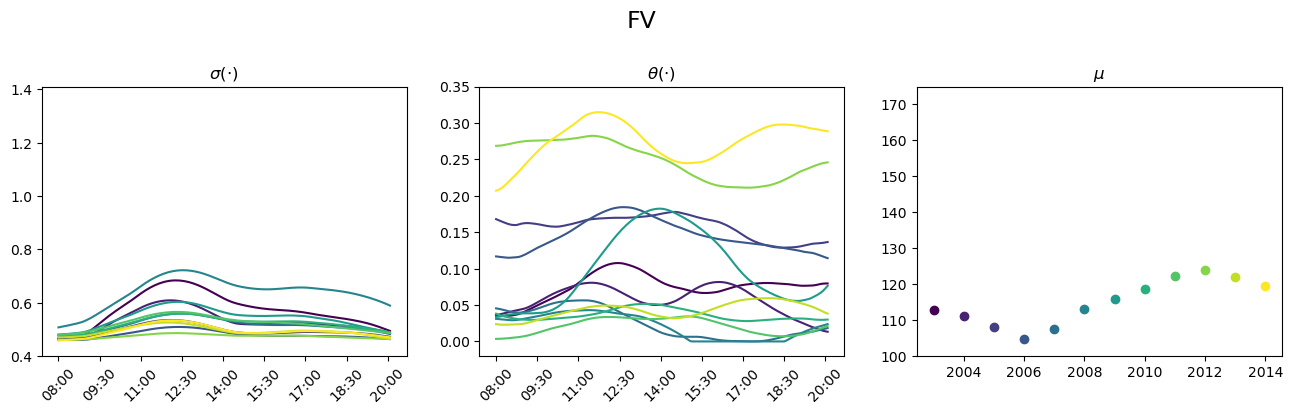

12it [00:31,  2.59s/it]


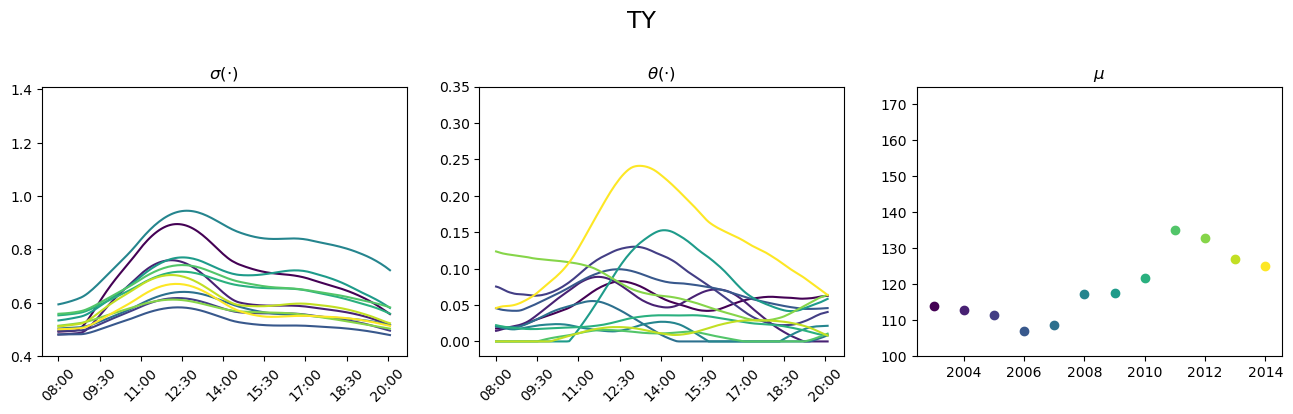

In [10]:
_hs = []; _ht = []; _hm = []; _R0_mean = []; _R0_std = []

bonds_names = ['US', 'FV', 'TY', 'TU']

for selected_bond in bonds_names[:-1]:
    fig, axs  = plt.subplots(figsize = (16,3.5), ncols = 3)
    fig.suptitle(selected_bond, fontsize = 17,y=1.1)    
    years = np.arange(2003, 2015)
    
    hs = []; ht = []; hm = []; R0_mean = []; R0_std = []
    for i, (selected_year, c) in tqdm(enumerate(zip(years,  plt.cm.viridis(np.linspace(0,1,years.size))))) :
        # import data
        Rs  = data['{}_{}'.format(selected_bond, selected_year)]['opening_values']
        Ts = data['{}_{}'.format(selected_bond, selected_year)]['times']
            
        # keep only samples of full length (excludes eg holidays), add artificial noise
        sizes = [_.size for _ in Rs]
        ixs_toKeep1 = np.where(np.array(sizes) == np.median(sizes))[0]
        Rs = np.array([_.ravel() + giveMeNoise(int(np.median(sizes))).ravel() for i, _ in enumerate(Rs) if i in ixs_toKeep1])
        # Rs = np.array([_.ravel() for i, _ in enumerate(Rs) if i in ixs_toKeep1])
        Ts = np.array([_  for i, _ in enumerate(Ts) if i in ixs_toKeep1])
        
        # keep only values when market is open
        strTs = [[ time.strftime('%H:%M') for time in T] for T in Ts] 
        Rs =np.array([ [r for r, t in zip(R,T) if t in open_time_list ] for R,T in zip(Rs,strTs)])
        Ts =np.array([ [_t for _t, t in zip(_T,T) if t in open_time_list ] for _T,T in zip(Ts,strTs)])
    
        # axes for plotting
        _where = np.array([ i for i,_ in enumerate(time_list) if _ in [time.strftime('%H:%M') for time in Ts[0]] ])
    
        # run estimation
        results = estimate_FVM(Rs ,h_qv = .65, h_mean = .65)
        hat_sigma = results['LLS_Der_mean_emp_QV']**.5
        hat_theta =((hat_sigma**2 - results['LLS_Der_variance'])/(2*results['LLS_variance']))
        hat_theta = np.array([_ if _>0 else 0 for _ in hat_theta]) 
        
        allhatmu = ((results['LLS_Der_mean'] + hat_theta*results['LLS_mean'])/hat_theta)[hat_theta>0]
        lower_bound = np.percentile(allhatmu, 25); upper_bound = np.percentile(allhatmu, 75);
        hat_mu = np.nanmedian(allhatmu[(allhatmu >= lower_bound) & (allhatmu <= upper_bound)])
    
        hs.append(hat_sigma); ht.append(hat_theta); hm.append(hat_mu)
        R0_mean.append(Rs[:,0].mean()); R0_std.append(Rs[:,0].std())
        
        axs[0].set_title('$\sigma(\cdot)$');axs[1].set_title('$\\theta(\cdot)$'); axs[2].set_title('$\mu$')
        axs[0].plot(_where,  hat_sigma, color=c, label = '{}'.format(selected_year));
        axs[1].plot(_where, hat_theta, color=c, label = '{}'.format(selected_year));
        axs[2].scatter(selected_year, hat_mu, color=c, label = '{}'.format(selected_year));

    every= 18
    datetime_with_dummy_date = [ datetime.combine(datetime(2000, 1, 1),t) for t in Ts[0]]
    my_delta = timedelta(hours=1, minutes=115)
    resulting_datetime = [t - my_delta for t in datetime_with_dummy_date]
    resulting_time = [ t.time() for t in resulting_datetime]
    
    strf_time  = np.array([ _ for _ in time_list if _ in [time.strftime('%H:%M') for time in resulting_time] ])[::every]
    
    axs[1].set_xticks(_where[::every]); axs[0].set_xticks(_where[::every]); 
    axs[0].set_xticklabels(strf_time ,rotation = 45); axs[1].set_xticklabels(strf_time,rotation = 45) 
    
    axs[0].set_ylim(0.4,1.41); axs[1].set_ylim(-.02,0.35); axs[2].set_ylim(100, 175)
    
    # axs[0].legend(bbox_to_anchor=(1.8, -0.3), fancybox=True, shadow=True, ncol=5); 
    
    _hs.append(np.array(hs).mean(0)) ; _ht.append(np.array(ht).mean(0)) ; _hm.append(np.array(hm).mean(0)) 
    _R0_mean.append(np.mean(R0_mean)); _R0_std.append(np.mean(R0_std))
    
    plt.savefig('fig/{}.png'.format(selected_bond), bbox_inches='tight')
    plt.show()

# fig, axs  = plt.subplots(figsize = (16,3.5), ncols = 3)
# scalarmappaple = cm.ScalarMappable( cmap=cm.viridis)
# scalarmappaple.set_array(years)
# cbar = plt.colorbar(scalarmappaple, ax= axs.ravel().tolist(), orientation = 'horizontal',shrink=.75,aspect = 50)
# cbar.ax.set_xlabel('Year', fontsize = 16, rotation=0)
# plt.show()
    

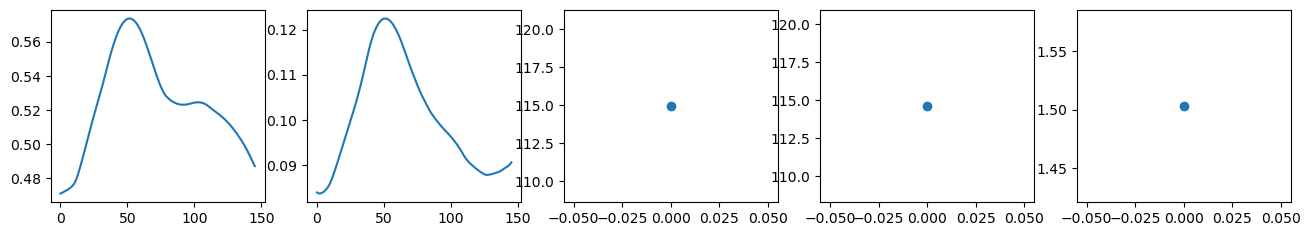

In [ ]:
import pickle

IX = 1


with open('../simulations_FinancialLike/params/example_params_00.pickle', 'wb') as file:
    pickle.dump({'sigma': _hs[IX], 'theta': _ht[IX], 'mu':_hm[IX], 'grid_size': _ht[IX].size, 'R0_mean' : _R0_mean[IX],  'R0_std' : _R0_std[IX], 'xticklabs' : strf_time},file)

fig, axs  = plt.subplots(figsize = (16,2.5), ncols = 5)
axs[0].plot(_hs[IX]); axs[1].plot(_ht[IX]);  axs[2].scatter(0,_hm[IX]);  axs[3].scatter(0,_R0_mean[IX]);  axs[4].scatter(0,_R0_std[IX]); 

In [70]:
selected_year = 2009
selected_bond = 'US'

data = {}
for file in os.listdir('./data_treasure_bonds'):
    try:
        data.update({file[:-4] : pd.read_csv('./data_treasure_bonds/{}'.format(file)).sort_values(['Date', 'Time'])})
    except:
        None
data.keys()

df = data[selected_bond].copy()
df['Date'] = pd.to_datetime(df['Date']).copy(); df['Time'] = pd.to_timedelta( df.Time + ':00'); df.loc[:,'Datetime'] =  df.Date + df.Time 

In [71]:
df_year =df[df.Datetime.dt.year == selected_year].sort_values('Datetime')
    
set_of_dates = df_year.Datetime.dt.date.unique()

Rs = []; dates = []; Ts = []
for date in (set_of_dates):
    temp_df = df_year.loc[df_year.Datetime.dt.date==date].copy(); 
    Rs.append(temp_df.Open.values); 
    dates.append(temp_df.Datetime.values);
    Ts.append(temp_df.Datetime.dt.time.values)

In [72]:
# keep only samples of full length (excludes eg holidays), add artificial noise
sizes = [_.size for _ in Rs]
ixs_toKeep1 = np.where(np.array(sizes) == np.median(sizes))[0]

Rs = np.array([_.ravel() + giveMeNoise(int(np.median(sizes))).ravel() for i, _ in enumerate(Rs) if i in ixs_toKeep1])
Ts = np.array([_  for i, _ in enumerate(Ts) if i in ixs_toKeep1])

# keep only values when market is open
strTs = [[ time.strftime('%H:%M') for time in T] for T in Ts] 
Rs =np.array([ [r for r, t in zip(R,T) if t in open_time_list ] for R,T in zip(Rs,strTs)])
Ts =np.array([ [_t for _t, t in zip(_T,T) if t in open_time_list ] for _T,T in zip(Ts,strTs)])

dates = np.array([_  for i, _ in enumerate(dates) if i in ixs_toKeep1])

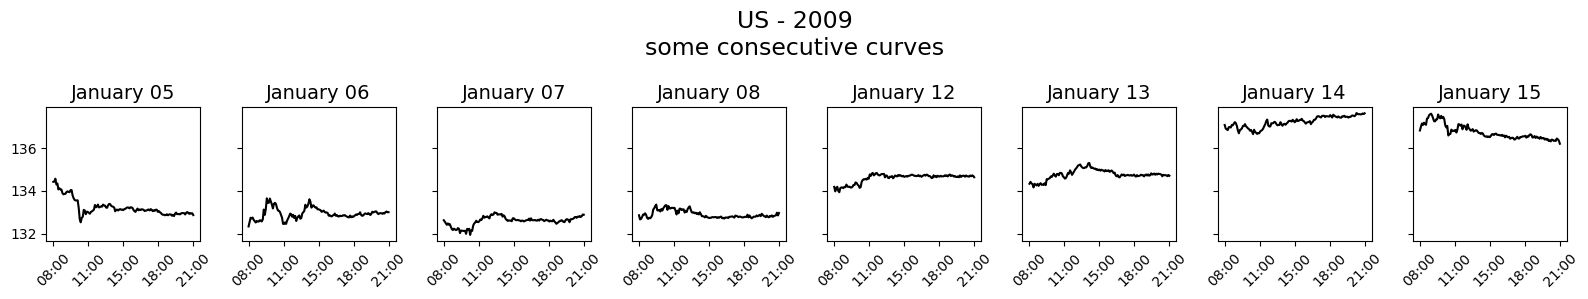

In [80]:

from datetime import datetime, timedelta
from matplotlib.ticker import ScalarFormatter

nrows = 1
fig, axs  = plt.subplots(figsize = (16,nrows*3), ncols = 8,nrows=nrows, sharey=True); axs= axs.ravel()
fig.suptitle('Some consecutive trajectories', fontsize = 22)
cmp = plt.cm.viridis(np.linspace(0,1,axs.size))
for i, (ax, R, date) in enumerate(zip(axs,Rs,dates)):
    ax.plot(np.linspace(0,1,R.size), R, c='k'); 
    axs[i].set_title(pd.to_datetime(date)[0].strftime("%B %d"), fontsize = 14)
    axs[i].set_xticks(np.linspace(0,1,len(strf_time[::2]))); axs[i].set_xticklabels(strf_time[::2], rotation = 45)
    # axs[i].yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))

fig.suptitle('{} - {}\nsome consecutive curves'.format(selected_bond, selected_year),fontsize = 17)
plt.tight_layout()

fig.savefig('fig/consecutive_trajectories'); plt.show()